In [1]:
# Imports & Initializations.
%load_ext autoreload
%autoreload 2
import os
import sys
import csv
import json
import time
import pickle
from pathlib import Path
from copy import deepcopy
import itertools
import contextlib

sys.path.append(str(Path().absolute().parent.absolute()))

import torch
import yaml
import comet_ml
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from experiment.query_configs import get_asap_normal, asap_num_e, asap_runtime
from experiment.util import get_metrics, plot_metrics, get_strong_baseline

check_repeat_ops = {
    "delete_repeat": False,
    "archive_repeat": False,
    "verbose": True,
}

prompts = list(range(1, 9))
result_path = Path().absolute().parent / "results"
pro_path = Path("/Volumes/DATA/exps/crowdsourcing")
WS = "ol"
pro = LocalCometProject(pro_path)
archive_repeat = False

baselines = ["ft", "ft_reg", "lwf", "icarl", "eeil", "lucir", "podnet", "lucir_cwd"]

/Users/ei/opt/miniconda/envs/torch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Imports & Initializations.
%load_ext autoreload
%autoreload 2
import os
import sys
import csv
import json
import time
import pickle
from pathlib import Path
from copy import deepcopy
import itertools
import contextlib

sys.path.append(str(Path().absolute().parent.absolute()))

import torch
import yaml
import comet_ml
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from experiment.query_configs import get_asap_normal, asap_num_e, asap_runtime
from experiment.util import get_metrics, plot_metrics, get_strong_baseline

check_repeat_ops = {
    "delete_repeat": False,
    "archive_repeat": False,
    "verbose": True,
}

prompts = list(range(1, 9))
result_path = Path().absolute().parent / "results"
pro_path = Path("/Volumes/DATA/exps/crowdsourcing")
WS = "ol"
pro = LocalCometProject(pro_path)
archive_repeat = False

baselines = ["ft", "ft_reg", "lwf", "icarl", "eeil", "lucir", "podnet", "lucir_cwd"]

/Users/ei/opt/miniconda/envs/torch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


asap:score-p2-lucir_cwd: Seed 1 has following configuration differences:
 {}
asap:score-p2-lucir_cwd: Seed 2 has following configuration differences:
 {}
asap:score-p2-eeol: Seed 2 has following configuration differences:
 {}
asap:score-p2-eeol: Seed 3 has following configuration differences:
 {}
asap:score-p2-eeol: Seed 4 has following configuration differences:
 {}


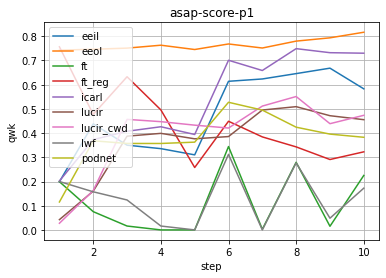

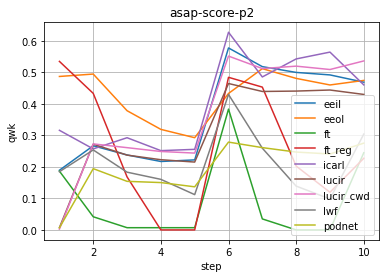

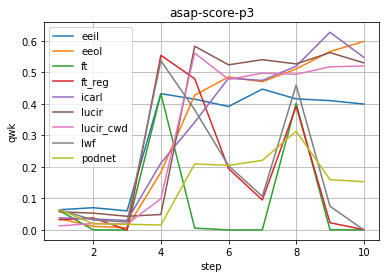

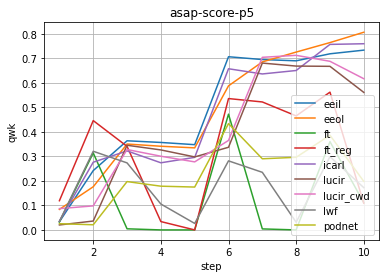

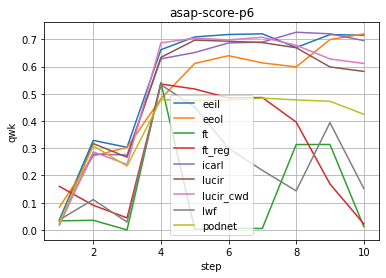

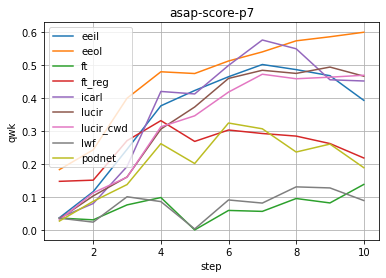

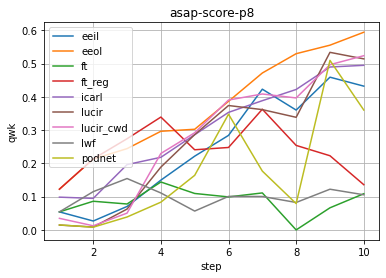

In [2]:
# asap random.
#### ASAP ####
# pro.update_dbs()

EPOCHS = 50
gen_results = True
plot_results = True

check_repeat_ops["archive_repeat"] = False
task = "score"
trainer_configs = get_asap_normal({"task;task": task, "train;num_epochs": EPOCHS})
seeds = [1, 2, 3, 4, 5]
# prompts = [2, 6]
# prompts = [1, 2, 3, 4, 5, 6, 7, 8]
prompts = [1, 2, 3, 5, 6, 7, 8]
# task = "score"
saving_keys = {p: {} for p in prompts}
for p in prompts:
    for tr, config in trainer_configs.items():
        config["data;prompt"] = p
        config["task;task"] = task
        if tr == "lucir_cwd":
            config["train;loss_args;fixed_lambda"] = 0.1
        if tr == "eeol":
            if p == 5:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.3
            elif p == 4:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.1
            elif p == 7:
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.5
            else:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.8
            # print(config)

        prefix_info = f"asap:{task}-p{p}-{tr}"
        keys = pro.query(config, return_experiments=False)
        keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
        keys = list(keys.values())
        missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
        saving_keys[p][tr] = keys
saving_keys["configs"] = trainer_configs

with open(result_path / f"asap-{task}-keys.yaml", "w") as f:
    yaml.dump(saving_keys, f)

if gen_results:
    with open(result_path / f"asap-{task}-keys.yaml", "r") as f:
        keys = yaml.safe_load(f)

    B = 10
    csv_results = {}
    results = {p: {} for p in prompts}
    seeds = [1, 2, 3, 4, 5]
    for p, pkey in keys.items():
        if p == "configs":
            results["configs"] = pkey
            continue
        for tr, ks in pkey.items():
            exps = [pro.get(k) for k in ks]
            exp_seeds = {exp.configs["task;seed"] for exp in exps}
            assert exp_seeds == set(seeds), f"p{p}_{tr}: {exp_seeds}"
            # print(p, tr, len(exps))
            results[p][tr] = get_metrics(exps, seeds)
    with open(result_path / f"asap-{task}-result.yaml", "w") as f:
        yaml.dump(results, f)

if plot_results:
    with open(result_path / f"asap-{task}-result.yaml", "r") as f:
        results = yaml.safe_load(f)
    for p, pms in results.items():
        if p != "configs":
            plot_metrics({tr: m["batch"] for tr, m in pms.items()}, f"asap-{task}-p{p}", "step", "qwk")


In [ ]:
# asap random ablation.
#### ASAP ####
# pro.update_dbs()

EPOCHS = 50
gen_keys = True
gen_results = True
plot_results = True

check_repeat_ops["archive_repeat"] = False
task = "random"
config = get_asap_normal({"task;task": task, "train;num_epochs": EPOCHS})["eeol"]
seeds = [1, 2, 3, 4, 5]
# prompts = [2]
prompts = [1, 2, 3, 4, 5, 6, 7, 8]
# prompts = [7]
# task = "score"
if gen_keys:
    saving_keys = {p: {} for p in prompts}
    for p in prompts:
        config["data;prompt"] = p
        if p == 5:
            config["task;smooth_factor"] = 6.0
            config["train;loss_args;t"] = 0.3
            config["train;loss_args;suppress_factor_at_2t"] = 0.3
        elif p == 4:
            config["task;smooth_factor"] = 6.0
            config["train;loss_args;t"] = 0.3
            config["train;loss_args;suppress_factor_at_2t"] = 0.1
        elif p == 7:
            config["train;loss_args;t"] = 0.3
            config["train;loss_args;suppress_factor_at_2t"] = 0.5
        else:
            config["task;smooth_factor"] = 6.0
            config["train;loss_args;t"] = 0.3
            config["train;loss_args;suppress_factor_at_2t"] = 0.8

        # Normal
        prefix_info = f"asap:{task}-p{p}-dss"
        keys = pro.query(config, return_experiments=False)
        keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
        keys = list(keys.values())
        missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
        saving_keys[p]["normal"] = keys
        config["normal_config"] = config
        saving_keys["configs"] = {"normal": deepcopy(config)}

        # DSS
        # config["task;cal_num_exemplars_per_class_method"] = "by_class"
        # prefix_info = f"asap:{task}-p{p}-dss"
        # keys = pro.query(config, return_experiments=False)
        # keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
        # keys = list(keys.values())
        # missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
        # saving_keys[p]["dss"] = keys
        # config["dss_config"] = config
        # saving_keys["configs"]["dss"] = deepcopy(config)
        # config["task;cal_num_exemplars_per_class_method"] = "by_num"

        # LOS
        config["train;loss_args;reject_order"] = "none"
        prefix_info = f"asap:{task}-p{p}-los"
        keys = pro.query(config, return_experiments=False)
        keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
        keys = list(keys.values())
        missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
        saving_keys[p]["los"] = keys
        config["los_config"] = config
        saving_keys["configs"]["los"] = deepcopy(config)
        config["train;loss_args;reject_order"] = "linear"

        # DEH
        config["log;note"] = "no_deh"
        prefix_info = f"asap:{task}-p{p}-deh"
        keys = pro.query(config, return_experiments=False)
        keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
        keys = list(keys.values())
        missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
        saving_keys[p]["deh"] = keys
        saving_keys["configs"]["deh"] = deepcopy(config)
        config["log;note"] = "QUERY v in ['', 'none']"

    with open(result_path / f"asap-{task}-ablation-keys.yaml", "w") as f:
        yaml.dump(saving_keys, f)

if gen_results:
    with open(result_path / f"asap-{task}-ablation-keys.yaml", "r") as f:
        keys = yaml.safe_load(f)

    B = 10
    csv_results = {}
    results = {p: {} for p in prompts}
    seeds = [1, 2, 3, 4, 5]
    for p, pkey in keys.items():
        if p == "configs":
            results["configs"] = pkey
            continue
        for tr, ks in pkey.items():
            exps = [pro.get(k) for k in ks]
            exp_seeds = {exp.configs["task;seed"] for exp in exps}
            assert exp_seeds == set(seeds), f"p{p}_{tr}: {exp_seeds}"
            results[p][tr] = get_metrics(exps, seeds)
    with open(result_path / f"asap-{task}-ablation-result.yaml", "w") as f:
        yaml.dump(results, f)

if plot_results:
    with open(result_path / f"asap-{task}-ablation-result.yaml", "r") as f:
        results = yaml.safe_load(f)
    for p, pms in results.items():
        if p != "configs":
            plot_metrics({tr: m["batch"] for tr, m in pms.items()}, f"asap-{task}-p{p}", "step", "qwk")


In [ ]:
# ASAP epochs
epochs = [1, 5, 10, 20, 30, 40, 50]
# epochs = [10, 20, 30, 40, 50]
seeds = [1, 2, 3, 4, 5]
prompts = [1, 2, 3, 4, 5, 6, 7, 8]
gen_keys = True
gen_results = True
plot_results = True
check_repeat_ops["archive_repeat"] = False
task = "random"
config = get_asap_normal({"task;task": task, "train;num_epochs": 50})["eeol"]
saving_keys = {p: {} for p in prompts}
if gen_keys:
    cnt = 0
    for epoch in epochs:
        config = get_asap_normal({"task;task": task, "train;num_epochs": epoch})["eeol"]
        for p in prompts:
            config["data;prompt"] = p
            config["task;seed"] = "QUERY v in [1, 2, 3, 4, 5]"
            # config["task;smooth_factor"] = 5.0
            # config["train;loss_args;t"] = 0.6
            # config["train;loss_args;suppress_factor_at_2t"] = 0.2
            if p == 4:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.1
            elif p == 5:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.3
            elif p == 7:
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.5
            else:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.8
            if epoch == 50:
                config["log;note"] = "QUERY v in ['', 'none']"
            else:
                config["log;note"] = "QUERY v in ['runtime_p100', 'runtime-p100']"

            prefix_info = f"asap:{task}-p{p}-eeol-epochs{epoch}"
            keys = pro.query(config, return_experiments=False)
            keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
            keys = list(keys.values())
            missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
            cnt += len(missing)
            saving_keys[p][epoch] = keys
    with open(result_path / "asap-random-eeol-epochs-keys.yaml", "w") as f:
        yaml.dump(saving_keys, f)
    print(f"Missing {cnt} in total.")

if gen_results:
    with open(result_path / "asap-random-eeol-epochs-keys.yaml", "r") as f:
        keys = yaml.safe_load(f)
    results = {p:{} for p in keys.keys()}
    for p, pkeys in keys.items():
        for epochs, ks in pkeys.items():
            exps = [pro.get(k) for k in ks]
            results[p][epochs] = get_metrics(exps, seeds)
    with open(result_path / "asap-random-eeol-epochs-result.yaml", "w") as f:
        yaml.dump(results, f)

if plot_results:
    with open(result_path / "asap-random-eeol-epochs-result.yaml", "r") as f:
        results = yaml.safe_load(f)
        for p, presults in results.items():
            plt.figure()
            fins = sorted([[epochs, m["fin"]] for epochs, m in presults.items()], key=lambda x: x[0])
            epochs, fin = zip(*fins)
            plt.plot(epochs, fin, label=str(epochs))
            plt.title(f"p{p}")
            plt.grid()
    plt.show()


In [ ]:
# ASAP num_e
# num_es = [x * 10 for x in list(range(1, 21))]
num_es = [10, 50, 100, 150, 200]
seeds = [1, 2, 3, 4, 5]
prompts = [1, 2, 3, 4, 5, 6, 7, 8]
gen_keys = True
gen_results = True
plot_results = True
check_repeat_ops["archive_repeat"] = False
task = "random"
config = get_asap_normal({"task;task": task, "train;num_epochs": 50})["eeol"]
saving_keys = {p: {} for p in prompts}
cnt = 0
if gen_keys:
    cnt = 0
    for num_e in num_es:
        for p in prompts:
            config["data;prompt"] = p
            config["task;total_num_exemplars"] = num_e
            # config["task;smooth_factor"] = 5.0
            # config["train;loss_args;t"] = 0.6
            # config["train;loss_args;suppress_factor_at_2t"] = 0.2
            if p == 4:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.1
            elif p == 5:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.3
            elif p == 7:
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.5
            else:
                config["task;smooth_factor"] = 6.0
                config["train;loss_args;t"] = 0.3
                config["train;loss_args;suppress_factor_at_2t"] = 0.8

            prefix_info = f"asap:{task}-p{p}-eeol-num_e{num_e}"
            keys = pro.query(config, return_experiments=False)
            keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
            keys = list(keys.values())
            missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
            cnt += len(missing)
            saving_keys[p][num_e] = keys
    with open(result_path / "asap-random-eeol-num_e-keys.yaml", "w") as f:
        yaml.dump(saving_keys, f)
    print(f"Missing {cnt} in total.")

if gen_results:
    with open(result_path / "asap-random-eeol-num_e-keys.yaml", "r") as f:
        keys = yaml.safe_load(f)
    results = {p:{} for p in keys.keys()}
    for p, pkeys in keys.items():
        for epochs, ks in pkeys.items():
            exps = [pro.get(k) for k in ks]
            results[p][epochs] = get_metrics(exps, seeds)
    with open(result_path / "asap-random-eeol-num_e-result.yaml", "w") as f:
        yaml.dump(results, f)

if plot_results:
    with open(result_path / "asap-random-eeol-num_e-result.yaml", "r") as f:
        results = yaml.safe_load(f)
        for p, presults in results.items():
            plt.figure()
            fins = sorted([[num_e, m["fin"]] for num_e, m in presults.items()], key=lambda x: x[0])
            num_e, fin = zip(*fins)
            plt.plot(num_e, fin, label=str(epochs))
            plt.title(f"p{p}")
            plt.grid()
    plt.show()

In [ ]:
# Runtime.
EPOCHS = 50
gen_keys = True
gen_results = True
plot_results = True

check_repeat_ops["archive_repeat"] = False
trainer_configs = asap_runtime
seeds = [1, 2, 3, 4, 5]
prompts = [1, 2, 3, 4, 5, 6, 7, 8]
B = 10
if gen_keys:
    saving_keys = {p: {} for p in prompts}
    for p in prompts:
        for tr, config in trainer_configs.items():
            config["train;num_epochs"] = EPOCHS
            config["log;note"] = "QUERY v in ['runtime_p100', 'runtime-p100']"
            config["data;prompt"] = p
            config["task;seed"] = "QUERY v in [1, 2, 3, 4, 5]"

            if tr == "joint":
                config["task;task"] = "joint"
            elif tr == "eeol":
                config["task;task"] = "random"
            else:
                raise ValueError(f"Unexpected tr {tr}")

            if tr == "eeol":
                if p == 5:
                    config["task;smooth_factor"] = 6.0
                    config["train;loss_args;t"] = 0.3
                    config["train;loss_args;suppress_factor_at_2t"] = 0.3
                elif p == 4:
                    config["task;smooth_factor"] = 6.0
                    config["train;loss_args;t"] = 0.3
                    config["train;loss_args;suppress_factor_at_2t"] = 0.1
                elif p == 7:
                    config["train;loss_args;t"] = 0.3
                    config["train;loss_args;suppress_factor_at_2t"] = 0.5
                else:
                    config["task;smooth_factor"] = 6.0
                    config["train;loss_args;t"] = 0.3
                    config["train;loss_args;suppress_factor_at_2t"] = 0.8

            prefix_info = f"asap:runtime-p{p}-{tr}"
            keys = pro.query(config, return_experiments=False)
            keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
            keys = list(keys.values())
            # print([pro.get_config(k)["train;trainer"] for k in keys])
            # exp = pro.get(keys[0])
            missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
            saving_keys[p][tr] = keys
    saving_keys["configs"] = trainer_configs

    with open(result_path / f"asap-runtime-keys.yaml", "w") as f:
        yaml.dump(saving_keys, f)

if gen_results:
    with open(result_path / f"asap-runtime-keys.yaml", "r") as f:
        keys = yaml.safe_load(f)

    results = {p: {} for p in prompts}
    seeds = [1, 2, 3, 4, 5]
    for p, pkey in keys.items():
        if p == "configs":
            results["configs"] = pkey
            continue
        for tr, ks in pkey.items():
            exps = [pro.get(k) for k in ks]
            exp_seeds = {exp.configs["task;seed"] for exp in exps}
            assert exp_seeds == set(seeds), f"p{p}_{tr}: {exp_seeds}"
            mean_duration = sum(exp.duration for exp in exps) / len(exps)
            results[p][tr] = get_metrics(exps, seeds)

    with open(result_path / f"asap-runtime-result.yaml", "w") as f:
        yaml.dump(results, f)


In [ ]:
# Compute strong baselines.
baseline_metrics = {p: {"fin": None, "inc": None, "fin_tr": None, "inc_tr": None} for p in prompts}

task = "score"
with open(result_path / f"asap-{task}-result.yaml", "r") as f:
    results = yaml.safe_load(f)

for p in prompts:
    baseline_metrics[p]["fin"], baseline_metrics[p]["fin_tr"], baseline_metrics[p]["inc"], baseline_metrics[p]["inc_tre"] = get_strong_baseline(results[p], baselines)

baseline_metrics["configs"] = results["configs"]

with open(result_path / f"asap-{task}-baseline.yaml", "w") as f:
    yaml.dump(baseline_metrics, f)


In [ ]:
# Check asap eeol hyperparameters.
#### ASAP ####
def get_paras(smooths, lossts, suppresses):
    return [(smooth, t, s) for smooth in smooths for t in lossts for s in suppresses]
# pro.update_dbs()

EPOCHS = 50
check_repeat_ops["archive_repeat"] = False

task = "score"
config = get_asap_normal({"task;task": task, "train;num_epochs": EPOCHS})["eeol"]
seeds = [1, 2, 3, 4, 5]

# All paras.
# smooths = list(range(2, 11))
# lossts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# suppresses = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# paras = get_paras(smooths, lossts, suppresses)

smooths = [6.0]
lossts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
suppresses = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
paras = get_paras(smooths, lossts, suppresses)

# smooths = [6.0]
# lossts = [0.3]
# suppresses = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# paras = get_paras(smooths, lossts, suppresses)

# smooths = [6.0]
# lossts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# suppresses = [0.8]
# paras += get_paras(smooths, lossts, suppresses)

smooths = list(range(2, 11))
lossts = [0.3]
suppresses = [0.8]
paras += get_paras(smooths, lossts, suppresses)

# prompts = [5, 7]
prompts = [2]
# prompts = [1, 2, 3, 4, 5, 6, 7, 8]

saving_keys = {p: {} for p in prompts}
# for p, smooth, losst, suppress in itertools.product(prompts, smooths, lossts, suppresses):
cnt = 0
for p, (smooth, losst, suppress) in itertools.product(prompts, paras):
    config["data;prompt"] = p
    config["task;smooth_factor"] = smooth
    config["train;loss_args;t"] = losst
    config["train;loss_args;suppress_factor_at_2t"] = suppress
    if "log;note" in config:
        del config["log;note"]

    prefix_info = f"asap:{task}-p{p}-smooth{smooth}-t{losst}-suppress{suppress}"
    keys = pro.query(config, return_experiments=False)
    keys, repeated = pro.check_repeat_seeds(keys, prefix_info=prefix_info, **check_repeat_ops)
    keys = list(keys.values())
    missing = pro.check_missing_seeds(keys, seeds, prefix_info=prefix_info, verbose=True)
    if len(missing) == 0:
        saving_keys[p][f"smooth{smooth}_t{losst}_suppress{suppress}"] = keys
    else:
        cnt += len(missing)
print(f"Missing {cnt} in total.")
saving_keys["configs"] = config
with open(result_path / f"asap-{task}-eeol-tuning-keys.yaml", "w") as f:
    yaml.dump(saving_keys, f)


In [ ]:
# Tuning.
task = "score"
seeds = [1, 2, 3, 4, 5]
gen_tuning_result = True
if gen_tuning_result:
    with open(result_path / f"asap-{task}-eeol-tuning-keys.yaml", "r") as f:
        keys = yaml.safe_load(f)
    results = {p: {} for p in prompts}
    fin_order = {p: [] for p in prompts}
    inc_order = {p: [] for p in prompts}
    for p, p_keys in keys.items():
        if p == "configs":
            results["configs"] = p_keys
            continue
        for para, ks in tqdm(p_keys.items()):
            exps = [pro.get(k) for k in ks]
            assert {exp.configs["task;seed"] for exp in exps} == set(seeds), f"p{p}_{para}"
            # with contextlib.suppress(Exception):
            results[p][para] = get_metrics(exps, seeds)
        tmp = [[para, m["fin"], m["inc"]] for para, m in results[p].items()]
        fin_order[p] = sorted(tmp, key=lambda x: x[1], reverse=True)
        inc_order[p] = sorted(tmp, key=lambda x: x[2], reverse=True)
        # print("fin p", p, fin_order[p][:5])
    with open(result_path / f"asap-{task}-eeol-tuning-results.yaml", "w") as f:
        yaml.dump(results, f)
else:
    with open(result_path / f"asap-{task}-eeol-tuning-results.yaml", "r") as f:
        results = yaml.safe_load(f)

with open(result_path / f"asap-{task}-eeol-tuning-order-fin.yaml", "w") as f:
    yaml.dump(fin_order, f)
with open(result_path / f"asap-{task}-eeol-tuning-order-inc.yaml", "w") as f:
    yaml.dump(inc_order, f)
# for p, pms in results.items():
#     if p != "configs":
#         plot_metrics({para: m["batch"] for para, m in pms.items()}, f"asap-{task}-p{p}", "step", "qwk")

with open(result_path / f"asap-{task}-baseline.yaml", "r") as f:
    strong_baselines = yaml.safe_load(f)
with open(result_path / f"asap-{task}-eeol-tuning-results.yaml", "r") as f:
    results = yaml.safe_load(f)
solution = {}
init = False
for p, p_ms in results.items():
    if p == "configs" or len(p_ms) == 0:
        continue
    base = strong_baselines[p]
    base_fin, base_fin_tr = base["fin"], base["fin_tr"]
    base_inc, base_inc_tr = base["inc"], base["inc_tr"]
    solution_p = [[para, m["fin"] - base_fin, m["inc"] - base_inc] for para, m in p_ms.items() if m["fin"] > base_fin]
    solution_p = sorted(solution_p, key=lambda x: x[1], reverse=True)
    solution_p = [{"para": tmp[0], "fin": tmp[1], "inc": tmp[2]} for tmp in solution_p]
    solution_paras = [tmp["para"] for tmp in solution_p]
    with open(result_path / f"asap-p{p}-tuning.yaml", "w") as f:
        yaml.dump(solution_p, f)
    if not init:
        solution = solution_paras
        init = True
    else:
        solution = [para for para in solution_paras if para in solution]
    print(f"Prompt {p}: {solution_p}")

with open(result_path / "asap-solution.yaml", "w") as f:
    yaml.dump(solution, f)
print("solution: ", solution)